# Tutorial

## ${}^{12}\rm{C}(p,\gamma)$

This notebook will demonstrate how to use **B**ayesian **$R$**-Matrix **I**nference **C**ode **K**it (BRICK) to:
* Construct a Python object that enables the calling of AZURE2 with an arbitrary input vector $\theta$.
* Set up priors for each of the sampled parameters and a corresponding prior ($\ln\Pi$) function.
* Set up a likelihood ($\ln\mathcal{L}$) function.
* Construct a posterior ($\ln\mathcal{P}$) function from the likelihood and prior functions.
* Sample the posterior ($\ln\mathcal{P}$) function with emcee.
* Preview the results.

In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt

from brick.azr import AZR

So, your savvy with AZURE2, you've set up your $R$-matrix analysis of the data in AZURE2, and you have an input file...

(If any of those statements are not true, get familiar with AZURE2, read the manual, and return here. BRICK's main component is an interface layer to AZURE2. No $R$-matrix calculations are performed/written inside BRICK. Those are obtained by passing parameters to AZURE2, treating it as a "black box". The goal is **not** to provide the functionality to construct an $R$-matrix model. The idea is that with an $R$-matrix model already constructed in AZURE2, one can now sample what was previously fit/optimized.)

Now, let's take that input file and construct an object that allows us to call AZURE2 with a given $\theta$.

In [2]:
azr = AZR('12C+p.azr')

That's it. All of the relevant pieces of the analysis you've constructed inside the AZURE2 GUI will be inferred – varied parameters, default values, normalization factors, data segments, segments without data, etc.

Let's take a look.

In [32]:
# How many parameters are going to be sampled?
nd = azr.config.nd
print(f'There are {nd} sampled parameters.')

There are 6 sampled parameters.


In [33]:
# What labels have been assigned to those parameters?
azr.config.labels

['$C_{1,1}^{(-0.5)}$',
 '$E_{1,1}^{(+0.5)}$',
 '$\\Gamma_{1,1}^{(+0.5)}$',
 '$\\Gamma_{1,2}^{(+0.5)}$',
 '$n_{0}$',
 '$n_{1}$']

We have an ANC, a level energy, two partial widths, and a couple normalization factors. Let's choose some priors. We will construct a list of distributions using SciPy.

In [34]:
from scipy import stats

In [35]:
priors = [
    stats.uniform(0, 5),
    stats.uniform(1, 5),
    stats.uniform(0, 50000),
    stats.uniform(-100, 200),
    stats.lognorm(0.1),
    stats.lognorm(0.1)
]

Now, we want to evaluate the prior (or log(prior)). We have to sum the logpdf of each distribution

In [36]:
def lnPi(theta):
    return np.sum([pi.logpdf(t) for (pi, t) in zip(priors, theta)])

So far, so good. Next, we'll set up the liklihood (or log(likelihood)) function. We'll assume that the data are random draws from uncorrelated Gaussian distributions centered at the $R$-matrix predictions. So, we have
$$
\mathcal{L} = \prod_i \frac{1}{\sqrt{2\pi}\sigma_i} e^{-\frac{1}{2}\left(\frac{y_i-\mu_i}{\sigma_i}\right)^2}~,
$$
where $y_i$ and $\sigma_i$ are the data points and uncertainties, respectively, and $\mu_i$ is the physical model prediction.

We work with $\ln{\mathcal{L}}$ to avoid the numerical difficulties of dealing with extremely small values. The product then becomes a sum,
$$
\ln{\mathcal{L}} = \sum_i \left[-\ln{(\sqrt{2\pi}\sigma_i)} - \frac{1}{2}\left(\frac{y_i-\mu_i}{\sigma_i}\right)^2\right]
$$

First, we'll read in $y$.

In [37]:
output_files = np.unique([seg.output_filename for seg in azr.config.data.segments])
data = np.vstack([np.loadtxt('output/' + of) for of in output_files])

In [38]:
data.shape

(242, 9)

According to the extremely well-document AZURE2 manual, the 6th and 7th columns are the cross sections and uncertainties, respectively. (Beware, whatever normalization factor is entered into the input file has been applied to this data. We're grabbing it here because it's conveniently already in the center-of-mass frame.)

In [39]:
x = data[:, 0] # COM energies
y_default_norm = data[:, 5] # cross sections * f
sigma_default_norm = data[:, 6] # cross section uncertainties * f

Let's take a look at the data. Not really relevant, but everyone likes plots.

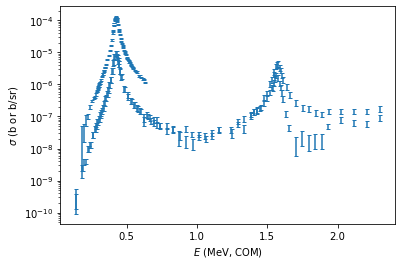

In [40]:
fig, ax = plt.subplots()
ax.errorbar(x, y_default_norm, yerr=sigma_default_norm, linestyle='', capsize=2)
ax.set_yscale('log')
ax.set_xlabel('$E$ (MeV, COM)')
ax.set_ylabel('$\sigma$ (b or b/sr)');

Now we can write the log(likelihood) function.

In [41]:
# To calculate the likelihood, we generate the prediction at theta and compare
# it to data. (Assumes data uncertainties are Gaussian and IID.)
# 
# Important Note: The data and uncertaintes returned by AZR have the normalization factor applied.
# Inside the argument to the exponential, that's exactly what we want.
# The pre-factor to the likelihood, however, must have the original, presumably unmodified, normalization.
def lnL(theta):
    output = azr.predict(theta)[0]
    mu = output.xs_com_fit
    y = output.xs_com_data
    sigma = output.xs_err_com_data
    return np.sum(-np.log(np.sqrt(2*np.pi)*sigma_default_norm) - 0.5*((y - mu)/sigma)**2)

Finally, we can write the log(posterior) function as a sum of the log(prior) and log(likelihood) functions.

In [42]:
def lnP(theta):
    lnpi = lnPi(theta)
    # If any of the parameters fall outside of their prior distributions, go
    # ahead and return -infinity . Don't bother running AZURE2 or risking
    # calling it with a parameter value that will throw an error.
    if lnpi == -np.inf:
        return lnpi
    return lnL(theta) + lnpi

Now, we are prepared to do the sampling.

In [48]:
import os
# Use the supported multithreading in emcee.
from multiprocessing import Pool

In [50]:
nw = 2*nd # number of walkers = 2 * number of sampled parameters

# Pick a point (theta) in parameter space around which we'll start each walker.
theta0 = [2.1, 2.37, 33600, -0.6325, 1, 1]
# theta0 = np.array(model.azr.config.get_input_values())
# theta0 = np.array([[pi.rvs() for pi in model.priors] for _ in range(nw)])

# Each walker needs its own starting position. We'll take normally distributed
# random values centered at theta0.
p0 = np.zeros((nw, nd))

mask = np.array([0.01, 0.0001, 0.01, 0.01, 0.01, 0.01]) # Widths of the Gaussians can be different.
for i in range(nw):
    mu = theta0
    sig = np.abs(theta0) * mask
    p0[i, :] = stats.norm(mu, sig).rvs()

In [52]:
# We'll store the chain in chain.h5. (See emcee Backends documentation.)
backend = emcee.backends.HDFBackend('chain.h5')
backend.reset(nw, nd)

nsteps = 10 # How many saved steps should each walker make?
nthin = 1 # How often should the walker save a step? n_total = nsteps * nthin
nprocs = nw # How many Python processes do you want to allocate?

# AZURE2 and emcee are both parallelized. We'll restrict AZURE2 to 1 thread to
# simplify things.
os.environ['OMP_NUM_THREADS'] = '1'

# emcee allows the user to specify the way the ensemble generates proposals.
with Pool(processes=nprocs) as pool:
    sampler = emcee.EnsembleSampler(nw, nd, lnP, pool=pool, backend=backend)
    state = sampler.run_mcmc(p0, nsteps, thin_by=nthin, progress=True, tune=True)

100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


This was only 10 steps. You are going to need more – a _lot_ more – if you want to obtain a significant number of independent samples. For this, I point you to `emcee`'s excellent documentation on [Autocorrelation Analysis & Convergence](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/).

Happy sampling.